In [2]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import requests

import math
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, LogNormal


from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions.bernoulli import Bernoulli

import IsoDatasets
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from collections import defaultdict




import gzip
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Helper functions

In [3]:
def load_data_chunk(filename, chunk_size=1000):
    """ Load a chunk of data from a gzipped TSV file. """
    return pd.read_csv(filename, sep='\t', compression='gzip', chunksize=chunk_size)

def separate_ids_and_data(data):
    ids = data.iloc[:, 0]
    data = data.iloc[:, 1:]
    return ids, data

def create_data_loaders(data_dir, batch_size, train_percent=0.8, load_in_mem=False):
    full_dataset = IsoDatasets.Archs4GeneExpressionDataset(data_dir, load_in_mem)
    train_size = int(train_percent * len(full_dataset))
    test_size = len(full_dataset) - train_size

    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

def plot_line(tensor, line_width=1.0):
    # Convert the Torch tensor to a NumPy array
    numeric_array = tensor.detach().numpy() if isinstance(tensor, torch.Tensor) else tensor

    plt.figure(figsize=(15, 5))
    plt.plot(numeric_array, linewidth=line_width)
    plt.title('Gene Expression Profile')
    plt.xlabel('Gene Index')
    plt.ylabel('Expression Level')
    plt.show()

# Kaiming initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

def is_nan(tensor):
    """ Check if a tensor is NaN """
    return torch.isnan(tensor).any()


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()

    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()

    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()

    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        # z = mu + sigma * epsilon
        return self.mu + self.sigma * self.sample_epsilon()

    def log_prob(self, z: Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        # Log probability for Gaussian distribution
        # log p(z) = -1/2 * [log(2*pi) + 2*log(sigma) + (z - mu)^2/sigma^2]
        return -0.5 * (torch.log(2 * torch.tensor(math.pi)) + 2 * torch.log(self.sigma) +
                       torch.pow(z - self.mu, 2) / torch.pow(self.sigma, 2))
    
    def count_csv_rows(filename):
        # If the file is gzip-compressed, decompress it first
        if filename.endswith('.gz'):
            with gzip.open(filename, 'rt', newline='') as csvfile:
                row_count = sum(1 for row in csvfile)
        else:
            # Specify the correct encoding (e.g., 'utf-8', 'latin-1', etc.)
            encoding = 'utf-8'  # Change to the appropriate encoding if needed
            with open(filename, 'r', newline='', encoding=encoding) as csvfile:
                row_count = sum(1 for row in csvfile)
        return row_count

## Load Data

In [4]:
# Define the file paths
archs4_path = "/dtu-compute/datasets/iso_02456/archs4_gene_expression_norm_transposed.tsv.gz"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/gtex_gene_expression_norm_transposed.tsv.gz"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/gtex_isoform_expression_norm_transposed.tsv.gz"
gtex_anno_path = "/dtu-compute/datasets/iso_02456/gtex_gene_isoform_annoation.tsv.gz"
gtex_tissue_path = "/dtu-compute/datasets/iso_02456/gtex_annot.tsv.gz"

# hdf5 paths:
archs4_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/archs4_gene_expression_norm_transposed.hdf5"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_gene_expression_norm_transposed.hdf5"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_isoform_expression_norm_transposed.hdf5"

num_genes = 18965
num_isoforms = 156958

num_genes, num_isoforms

(18965, 156958)

### Data Loader

In [5]:
# !zcat /dtu-compute/datasets/iso_02456/archs4_gene_expression_norm_transposed.tsv.gz | wc -l
print("archs4_path num rows: 167885")

archs4_path num rows: 167885


In [6]:
# Here is an example of loading the Archs4 gene expression dataset and looping over it
# If you have about 12GB of memory, you can load the dataset to memory using the argument load_in_mem=True

archs4_train_dataloader, archs4_test_dataloader = create_data_loaders(
    "/dtu-compute/datasets/iso_02456/hdf5/",
    batch_size=64,
    train_percent=0.8,
    load_in_mem=False  # Set to False to avoid MemoryError
)


In [7]:
genes = next(iter(archs4_train_dataloader))
print(genes.shape)
genes[0]

torch.Size([64, 18965])


tensor([4.4579, 0.0496, 1.5922,  ..., 7.0266, 2.7013, 3.5277])

In [8]:
train_loader = archs4_train_dataloader
test_loader = archs4_test_dataloader

## Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [17]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """

    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()

        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)


        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features), # <- note the 2*latent_features
            nn.ReLU(),
        )

        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""

        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)

        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_params = self.decoder(z)
        px_params = px_params.view(-1, *self.input_shape) # reshape the output
        return LogNormal(px_params, 1.0) # Assuming variance of 1


    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""

        # flatten the input
        x = x.view(x.size(0), -1)

        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)

        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}


    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""

        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)

        # sample the prior
        z = pz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta

    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:

        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        # compute the ELBO with and without the beta parameter:
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here

        # loss
        loss = -beta_elbo.mean()

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}

        return loss, diagnostics, outputs


Test VAE and Variational Inference

In [18]:
latent_features = 500
vae = VariationalAutoencoder(genes[0].shape, latent_features)
print(vae)

vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae, genes)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=18965, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1000, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=18965, bias=True)
  )
)


ValueError: Expected value argument (Tensor of shape (64, 18965)) to be within the support (GreaterThan(lower_bound=0.0)) of the distribution LogNormal(), but found invalid values:
tensor([[4.4579e+00, 4.9582e-02, 1.5922e+00,  ..., 7.0266e+00, 2.7013e+00,
         3.5277e+00],
        [6.7693e+00, 0.0000e+00, 1.0984e+00,  ..., 7.9656e+00, 3.1526e+00,
         4.4446e+00],
        [6.7342e+00, 3.4468e-02, 2.5089e+00,  ..., 9.0695e+00, 4.5277e+00,
         4.8312e+00],
        ...,
        [5.0820e+00, 8.8436e-03, 2.5323e+00,  ..., 9.2120e+00, 4.4000e+00,
         5.0375e+00],
        [3.4712e+00, 3.2355e-01, 2.5267e-02,  ..., 7.3658e+00, 4.9120e+00,
         6.0814e+00],
        [4.1269e+00, 1.3854e-01, 3.2515e+00,  ..., 5.6907e+00, 4.2962e+00,
         4.6739e+00]])

## Training and Evaluation

### Initialize the model, evaluator and optimizer

### Training Loop

In [14]:
print(torch.__version__)
print(torch.version.cuda)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

1.10.2+cu102
10.2
>> Using device: cpu


Training loop

In [19]:
# define the models, evaluator and optimizer
num_epochs = 3 # 100
latent_features = 500

train_losses = []
val_losses = []

# VAE
vae = VariationalAutoencoder(genes[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = vae.to(device)

epoch = 0
pseudocount = 1e-8
while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for x in train_loader_tqdm:
        x = x.to(device)

        # Avoid LogNormal getting 0 values
        pseudocount = 1e-8
        x = x+pseudocount

        loss, diagnostics, outputs = vi(vae, x)
        train_losses.append(loss.item())

        # Check if loss is NaN
        if is_nan(loss):
            print("Error: Loss became NaN during training")
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

        train_loader_tqdm.set_postfix(loss=loss.item())

    if is_nan(loss):
        break  # Stop training if loss is NaN

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()
        validation_epoch_data = defaultdict(list)

        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs} [Test]")
        for x in test_loader_tqdm:
            x = x.to(device)
            x = x+pseudocount

            loss, diagnostics, outputs = vi(vae, x)
            val_losses.append(loss.item())

            # Check if loss is NaN
            if is_nan(loss):
                print("Error: Loss became NaN during validation")
                break

            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]

            test_loader_tqdm.set_postfix(loss=loss.item())

        if is_nan(loss):
            break  # Stop validation if loss is NaN

        for k, v in validation_epoch_data.items():
            validation_data[k] += [np.mean(validation_epoch_data[k])]

>> Using device: cpu


Epoch 1/3 [Train]:   2%|▏         | 44/2099 [00:15<12:03,  2.84it/s, loss=1.19e+16]


KeyboardInterrupt: 

### Test model with a few batches only

Train with a few batches

In [32]:
# Your model, optimizer, and other setup code remains the same

num_epochs = 2  # Number of epochs
num_batches = 2099  # Max batches
num_batches = 500  # Number of batches to train on

train_losses = []
val_losses = []


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = VariationalAutoencoder(genes[0].shape, latent_features)
# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

# vae.apply(initialize_weights)


vae = vae.to(device)

epoch = 0
pseudocount = 1e-8
while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()

    # Wrapping the train_loader with tqdm
    train_loader_tqdm = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for i, x in train_loader_tqdm:
        if i >= num_batches:
            break  # Stop after processing a few batches

        x = x.to(device)

        # Avoid LogNormal getting 0 values
        x = x+ pseudocount

        loss, diagnostics, outputs = vi(vae, x)

        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

        # Update tqdm bar with loss info
        train_loader_tqdm.set_postfix(loss=loss.item())

    # Aggregate and store the training data
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(v)]

    # Quick validation step on a few batches
    with torch.no_grad():
        vae.eval()
        validation_epoch_data = defaultdict(list)

        # Wrapping the test_loader with tqdm
        test_loader_tqdm = tqdm(enumerate(test_loader), total=num_batches, desc=f"Epoch {epoch}/{num_epochs} [Test]")
        for i, x in test_loader_tqdm:
            if i >= num_batches * 0.2:
                break  # Validate on a few batches only

            # Avoid LogNormal getting 0 values
            x = x+ pseudocount

            x = x.to(device)
            loss, diagnostics, _ = vi(vae, x)
            val_losses.append(loss.item())

            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]

            # Update tqdm bar with loss info for validation
            test_loader_tqdm.set_postfix(loss=loss.item())

        # Aggregate and store the validation data
        for k, v in validation_epoch_data.items():
            validation_data[k] += [np.mean(v)]

# Print or analyze your training_data and validation_data

training_data['elbo']

>> Using device: cpu


Epoch 2/2 [Test]:  20%|██        | 100/500 [00:06<00:27, 14.34it/s, loss=1.45e+5]


[-198607.91090625, -148398.93275]

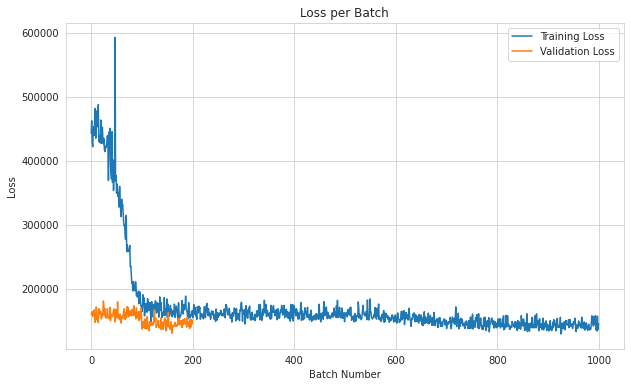

In [34]:
def plot_losses(losses_dict):
    """
    Plots the training and validation losses on the same plot.

    Parameters:
    losses_dict (dict): A dictionary where keys are loss types (e.g., 'Training', 'Validation') 
                        and values are lists of loss values.
    """
    plt.figure(figsize=(10, 6))
    
    for type, losses in losses_dict.items():
        plt.plot(losses, label=f'{type} Loss')
    
    plt.title('Loss per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

losses_dict = {
    "Training": train_losses,
    "Validation": val_losses
}
plot_losses(losses_dict)


Gradient Clipping (not tested yet)

In [ ]:
'''
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1)
optimizer.step()
'''

Check where the nan values come from

Model details

In [68]:
print("It takes around 10-14 min per epoch")

It takes around 10-14 min per epoch


Save and Load model

In [39]:
# Save the model to a file
torch.save(vae.state_dict(), 'vae_model.pth')

In [66]:
# input_shape = vae.input_shape
input_shape = torch.Size([18965])
input_shape

torch.Size([18965])

In [ ]:
# Load the model from a file
vae = VariationalAutoencoder(genes[0].shape, 100) # second parameter is number of latent features that the model whas trained on (backed up model is 100)
vae.load_state_dict(torch.load('models/vae_model_backup.pth'))

## Evaluate model

- KL Divergence
    - For VAEs, it's used to quantify how much the learned distribution (the posterior) deviates from the prior distribution, so it acts a  regularizer, ensuring that the variational distribution doesn't stray too far from the prior.
    - Interpretation: A KL divergence of 0 indicates that the two distributions are identical. The greater the KL divergence, the more the distributions differ.
    - Usage in VAEs: In VAEs, the KL divergence is used as a regularizer in the loss function to ensure that the distribution of the latent variables (encoded representations) doesn't deviate too much from a prior distribution (often a Gaussian). This helps in generalizing the model and avoiding overfitting to the training data.
- ELBO:
    - It's essentially a measure of how well the decoder can reconstruct the input from the latent variables.
    - How do we know if ELBO is good?
        - Summary: Look for improvement over epochs, combine with Qualitative Analysis on reconstructed data, and compare with baseline.
        - Depends on the Data: The ELBO is influenced by the complexity and characteristics of your dataset. Different datasets will naturally lead to different ranges of ELBO values. High-dimensional, complex data might result in lower ELBOs compared to simpler, lower-dimensional data.
        - Relative, not Absolute: The ELBO is more useful as a relative measure than an absolute one. This means you generally use ELBO to compare different models or configurations on the same dataset. An improvement in ELBO from one model iteration to the next can indicate progress.
        - Negative Values: ELBO values are often negative (since they involve log probabilities), and a higher (less negative) value is typically better. But without comparing to a baseline or other models, it's hard to label a specific number as good.
        - Model and Task Specific: The interpretation of ELBO can also depend on the specific use case of the model. For instance, if you're using a VAE for generative purposes, the quality of generated samples might be more important than the ELBO value itself.
        - Balance Between Components: ELBO combines reconstruction loss (how well the model can recreate input data) and the KL divergence (how much the model's latent variable distribution deviates from a prior distribution). The balance between these two can vary. A "good" ELBO in one context might mean excellent reconstruction at the cost of higher KL divergence, or vice versa.
        - Baseline Comparison: Compare your model's ELBO to that of a baseline model or a simpler version of your current model.
    - Improving the ELBO score means the model is getting better at compressing the data into a meaningful, compact form while also keeping its representations realistic and generalizable.
    - KL divergence it's part of the ELBO Loss together with the Reconstruction Loss that is how well the model can recreate the input data from its internal representation.

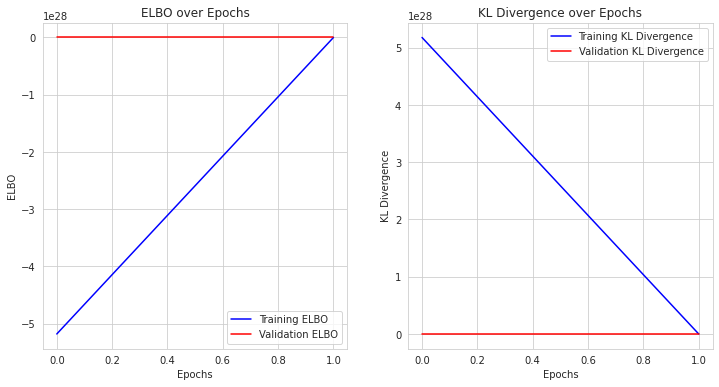

In [41]:
# Set up a figure and axis for the plots
plt.figure(figsize=(12, 6))

# Plot ELBO
plt.subplot(1, 2, 1)
plt.plot(training_data['elbo'], label='Training ELBO', color='blue')
plt.plot(validation_data['elbo'], label='Validation ELBO', color='red')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO over Epochs')
plt.legend()

# Plot KL Divergence
plt.subplot(1, 2, 2)
plt.plot(training_data['kl'], label='Training KL Divergence', color='blue')
plt.plot(validation_data['kl'], label='Validation KL Divergence', color='red')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

# Display the plot
plt.show()


In [43]:
# Sample from the prior
sampled_data = vae.sample_from_prior(batch_size=10)
generated_samples = sampled_data['px'].mean  # Assuming Bernoulli distribution

generated_samples.shape


torch.Size([10, 18965])

In [64]:
# Sample a batch from your data
x = next(iter(test_loader))
x = x.to(device)

# Forward pass through the VAE
outputs = vae(x)
z = outputs['z'].cpu().detach().numpy() # z is the latent space
print(f"Latent space size: {z.shape[1]}")
print(z.shape)

Latent space size: 100
(64, 100)


In [45]:
# Forward pass through the VAE
reconstructed_data = outputs['px'].mean  # Assuming Bernoulli distribution

# Compare original 'x' and 'reconstructed_data' visually or with a metric
reconstructed_data.shape

torch.Size([64, 18965])

### Plot VAE data

Generated Gene VS Real Gene

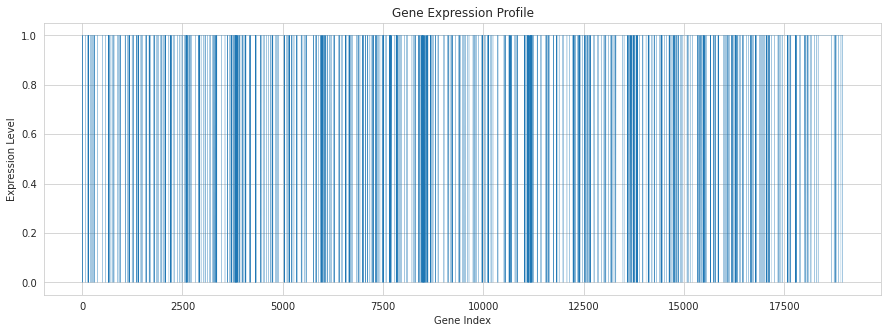

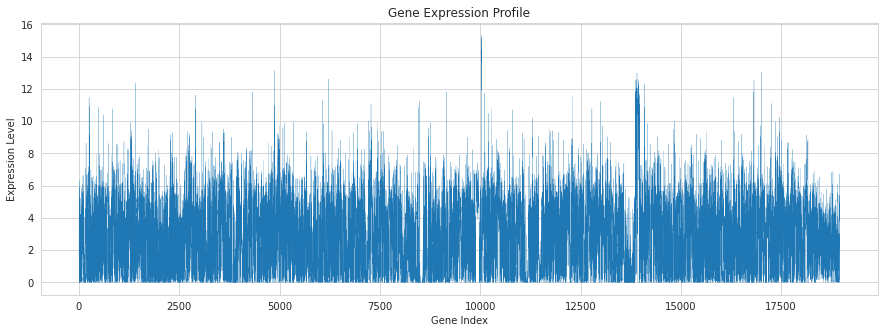

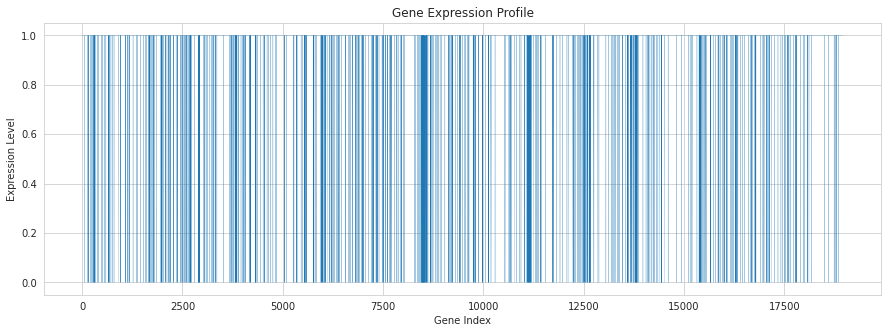

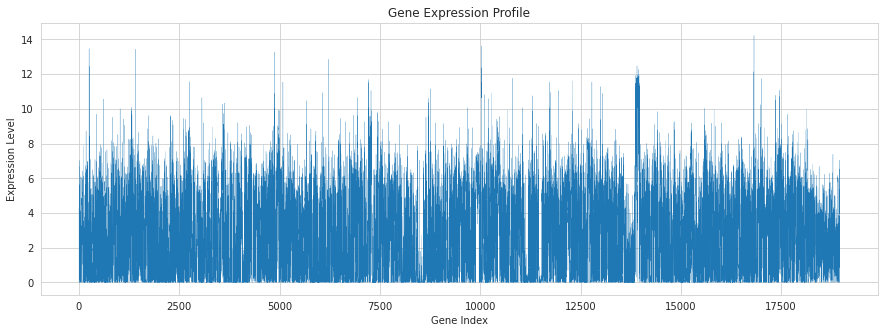

In [69]:
plot_line(reconstructed_data[0], line_width=0.2)
plot_line(genes[0], line_width=0.2)
plot_line(reconstructed_data[1], line_width=0.2)
plot_line(genes[1], line_width=0.2)

We can see that our model generates genes with values that are wither 0 or 1, while a real gene have values that go from 0 to 14. Further steps include checking that model architecture is correct, and improve model by augmenting latent space and epochs.

Latent space sample

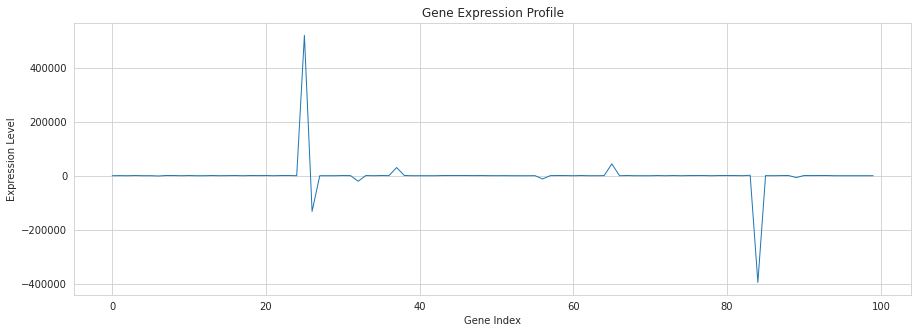

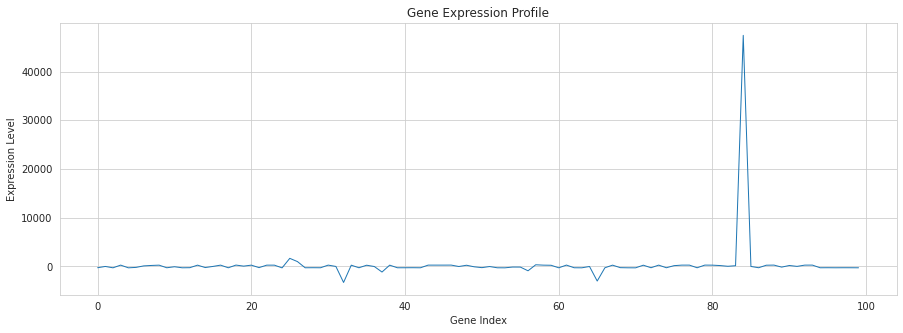

In [71]:
plot_line(z[0], line_width=1)
plot_line(z[1], line_width=1)

# Analyzing the VAE



### Exercise 3.

**Experiment with the VAE model.**

1. Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
3. Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions?

**Answers**:

1. We tried going deeper by adding 1 and 2 layers without seeing much difference. However, if we go shallower by removing one layer both the reconstruction and generative results get worse, though we can still recongnize some digits.
As for the activation functions we tried LeakyRelu with pretty much the same results, maybe slightly worst. The plots are available at the end of the notebook.
3. Increasing the number of units in the latent layer to 4 improved the model reconstruction and generation capabilities, where it still has some trouble differentiating between 9 and 4 but it performs better than before. This happens because when we increase the units, the latent space becomes capable of capturing more complex patterns and nuances in the data.

### Exercise 4.

**Analyze the purpose of the KL-term and the $\beta$ parameter.**

1. How does the KL-term, $\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$, work as a regulariser on the distributions over latent variables? *HINT*: When maximising the ELBO, the probability-distance measure is minimised $\operatorname{KL} \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $\operatorname{KL} = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal (i.e. $\mathbf{z}=\epsilon \sim \mathcal{N}(0,I)$) to the decoder.
2. Try removing the KL-term (using the $\beta$ parameter) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it.
3. What does the loss reduces to? Explain how this can affect a VAE. *HINT*: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p_\theta(\mathbf{x}|\mathbf{z}) = \log \mathcal{B}(\mathbf{x} | g_\theta(z))$, in VAEs.
4. Experiment with different $\beta$ values (e.g. [0.1, 10, 50]) and explain how this affects the reconstruction quality and the latent representations. *HINT* what is the tradeoff between reconstruction error ($\log p_\theta(\mathbf{x} | \mathbf{z})$) and the KL term?

**Answers**:

1. The KL-term, measures the divergence between two distributions: the approximate posterior and the prior, which is typically a standard normal distribution N(0,I). As the ELBO is maximized, the KL-term aims to be minimized. When it reaches 0, it indicates that the approximate posterior is the same as the prior. This means that the latent variables are not being influenced by the input data x and are essentially just noise sampled from N(0,I). Thus, the KL-term acts as a regularizer by ensuring that the latent representations don't stray too far from a prior belief (which is the standard normal distribution in most VAEs). Without this term, the latent variables might fit too closely to the training data, leading to overfitting.
2. By removing the KL-term (setting $\beta$=0), the VAE doesn't have any regularization on the latent space. This means the model focuses solely on the reconstruction error. We can observe:
 - The latent representation is probably more overfitted to the training data.
 - The reconstructions might be sharper initially but could lead to overfitting, where it performs well on training data but poorly on unseen data.  
 Also for this part we experimented errors during the execution, only for beta=0. When we went above 40 epochs, most of the times we got a Cuda error that can be seen in the Annex. Not sure of why this happens and if the student reading this have any idea I would appreciate the feedback.  
3. Without the KL-term, the VAE loss reduces to just the reconstruction error. In this scenario, the VAE becomes more like a traditional autoencoder (AE). This can lead to overfitting more easily just like an AE.  
4. We can see the following differences:
 - A smaller $\beta$ (e.g., 0.1): Puts less emphasis on the KL-term, leading to better reconstructions but poorer generalization and more complex latent representations.
 - $\beta$ =1: This is the standard VAE, which balances reconstruction with regularization from the KL-term.
 - A larger $\beta$ (e.g., 10, 50): Puts more emphasis on the KL-term, leading to simpler latent representations but potentially worse reconstructions. But for $\beta$=50 specifically, both reconstructions and generations are diffuse and bad.

 The trade-off is that As $\beta$ increases, the model prioritizes making the approximate posterior close to the prior, often at the expense of reconstruction quality. Conversely, as $\beta$ decreases, the model prioritizes reconstruction, potentially at the expense of generalization.

